# Answering the Question: What characters does The Data say I should use?
## Author: Kevin Stull


## Introduction
Fire Emblem Engage presents us with a simple problem, given 36 possible characters, which 10 or so should we put on our team? Should I just commit to the weaker early game character or hold off for this character in the late-game? What characters are best? 

## Spoiler Warning 
There are going to be (heavy) spoilers in the article. There are many plot-relevant playable characters in FE Engage. We are literally examining every unit in the game so it is assumed that the player is farmiliar with (or does not care about) the plot of Fire Emblem Engage.

## What We Are Going To Do 
There are three things that we need to consider; bases, growths, and availability. The first two have been investigated in article 1. The tricky part is deciding how to deal with the character's availability. For example, in the first article we saw that Mavier had the highest total growths and the highest total bases, however he was the worst character in terms of availability, being the last obtainable character on the roster of 36. Simply stating that Mavier is the best tank and moving on does not help us, because we will have to complete most of the game before even getting to him, so what characters should we have used in the mean time. On the other end of the spectrum, barring Alear, most of the characters obtained very early are quite poor (Etie, Bucheron, ect.). The first characters that seemed to be worth considering were Alfred and Citrine, which isn't suprising since they are "plot-relevant" characters with unique promotions. However, at the same time, we meet characters like Louis and Chloe, some more fan favorites. To address this we are going to leverage a machine learning technique called regression. 

## What is Regression and Why Will it Help?
Regression is a simple concept with some powerful applications. Let us start by imagining that we have a graph of all the characters in the game where the x-axis represents what chapter you can recruit them and y represents how powerful they are. We saw from article 1 that later on in the game, characters tend to have more bases and better growths, thus as x increases so does y.

To perform regression, we will try to find constants A, B, and C such that $Ax^2 + Bx + C$ predicts about how strong (y) a unit will be at some chapter (x) in the game. 

I selected a quadratic (function with x to the power of 2) because that is what the curves roughly looked like in article 1. Once we have this line that predicts how strong we expect a unit to be at some chapter, we will look at which characters are the furthest above that curve. That would mean that these characters are much stronger than we would expect a character to be at that chapter of the game. Thus, giving XP to them will on average lead to a stronger character later on in the game even if we encounter another unit that might fill the same role.

## Example: Which Character Should We Use? 
Let's say we need to choose between using Etie, Kagetsu, Timerra, and Lindon on our team. Lindon has better bases than everyone else but is only available very late. Etie has worse base stats than everyone else but is available earlier than everyone else. The red line indicates how strong we believe a unit should be at some chapter in the game. Kagetsu has the same as (or even slightly better) base stats than Timerra and is available 2 chapters earlier. That means that Kagetsu is stronger than we would typically expect a unit with his availability to be. He is a positive outlier on our Desirability Chart so we should select him for our team. 

## Plot of Unit Desirability

<img src="/Users/kevinstull/Documents/projects/FE_Engage/Article_2/figs/Screenshot 2024-01-12 at 11.46.44 AM.png" alt="Description of the image" width="650" height="500">


## Basic Approach 
1) Create a graph containing all the characters where x is the chapter you can recruit them and y is their power level. 
2) Use regression to find a best-fit quadratic function to our data 
3) Rank all of the character's desirability in terms of how far above the expected powere level line they are 
4) Select the top N characters to build your team (where N is the size of your team)

## Assumptions 
In order to answer this question we are going to make a few assumptions. Number 1, we will assume that the classes are balanced, this means that a lvl 10 swordmaster is just as strong as a lvl 10 mage. While this assumption is almost certainly flawed, it gives us a nice starting point for our investigation which we can remove in later articles. 2nd, we are going to assume that every unit will have average growths. We could also investigate when certain characters become better or worse given random level ups, or just the level up schedule Nintendo provided, but for now, just to simplify things, we assume that the units always perfectly follow their growth curves. Lastly, we will ignore their innate skills. Obviously some characters have better innate abilities that others, but it isn't clear how one would quantify them numerically, so we will assume they are all even and in the case of ties, their passive can be used as a "tie-breaker". With that, we are ready to dive in! 



## Who is the best physical tank to use? 
We are going to look for the best physical tank, which we expect to have high HP and Def. We will be using min-max normalization, if you need a refresher on that go see the last section of article 1! Basically, we are going to normalize HP and Def growths then add them together, we will do the same for bases, then we will add the growths to the bases to get an idea of how strong the character is for physical tanking. We should expect characters like Mauvier and Louis to be near the top of this graph and characters like Lindon and Citrine to be near the bottom. 


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df):
    # Initialize MinMaxScalers
    scalers = {feature: MinMaxScaler() for feature in features}

    # Create copies of DataFrames
    bases_norm = df_char_bases.copy()
    growths_norm = df_char_growths.copy()

    # Normalize features
    for feature in features:
        bases_norm[feature] = scalers[feature].fit_transform(bases_norm[[feature]])
        growths_norm[feature] = scalers[feature].fit_transform(growths_norm[[feature]])

    # Create 'phys_tank' columns
    bases_norm[f_name] = bases_norm[features].sum(axis=1)
    growths_norm[f_name] = growths_norm[features].sum(axis=1)

    # Combine 'Name' and 'phys_tank' columns
    combined_df['Name'] = bases_norm['Name']
    combined_df[f_name] = bases_norm[f_name].values + growths_norm[f_name].values

    return combined_df
    

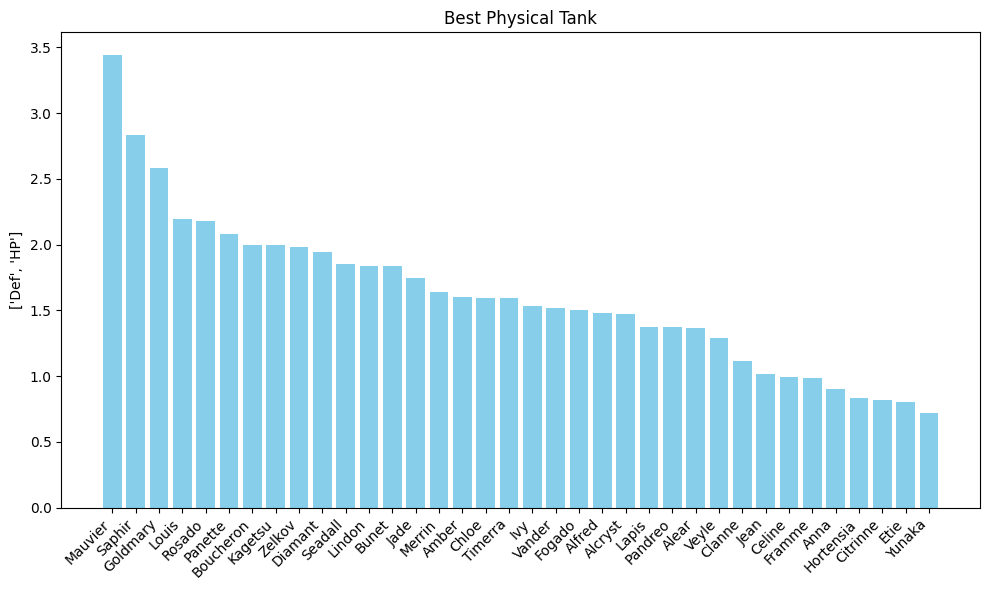

In [7]:
df_char_bases = pd.read_csv('fe_17_data_char_bases.csv')
df_char_growths = pd.read_csv('fe_17_data_char_growths.csv')
df_char_bases = df_char_bases.sort_values(by='Name').reset_index(drop=True)
df_char_growths = df_char_growths.sort_values(by='Name').reset_index(drop=True)
temp = pd.merge(df_char_bases, df_char_growths[['Name', 'Ch_Rec']], on='Name', how='left')
df_char_bases['Ch_Rec'] = temp['Ch_Rec'] 

# Our Combined Data Frame for Regression 
combined_df = pd.DataFrame()

# Physical Tank
features = ['Def', 'HP'] 
f_name = 'phys_tank'

combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)
combined_df_sorted = combined_df.sort_values(by=f_name, ascending=False).copy()

plt.figure(figsize=(10, 6))
plt.bar(combined_df_sorted['Name'], combined_df_sorted[f_name], color='skyblue')
plt.ylabel(str(features))
plt.title('Best Physical Tank')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Summary of Results for Best Physical Tank 
The results that we see are mostly what we expected, characters like Louis are near the top and Citrinne is near the bottom. Surpisingly, Lindon is near the middle. This is because in general, characters that are acquired later in the game tend to have better growths and bases. Still, Louis being obtainable very early (chapter 4), even though he is the 4th best physical tank means that he might be a promising option. However, he is significantly weaker than Goldmary (Chapter 16), so should we use Louis or hold out for Goldmary? 

## Regression for Physical Tanking (Finally!)
Now that we have quantified how good each unit is at physical tanking, we will perform a regression on that data to fit a prediction line based on the chapter they are recruitable. Scikit-learn has some pre-build functions that do different forms of regression, we will hbe using quadratic ridge regression, which has 3 variables and penalizes large values. 

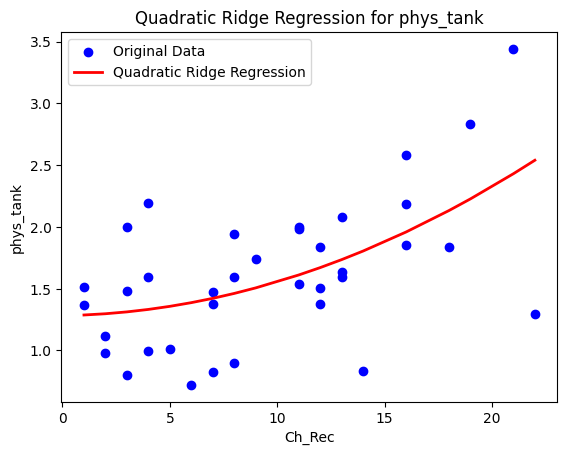

         Name  residuals
24    Mauvier   1.011312
23      Louis   0.863490
5   Boucheron   0.687838
15   Goldmary   0.625503


In [8]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

def regression_analysis(f_name, plot = True):
    X = df_char_bases['Ch_Rec'].values.reshape(-1, 1)
    y = combined_df[f_name].values
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    ridge_model = Ridge(alpha=1.0) 
    ridge_model.fit(X_poly, y)
    y_pred = ridge_model.predict(X_poly)
    if plot:
        plt.scatter(X, y, color='blue', label='Original Data')
        X_sorted = np.sort(X, axis=0)
        X_poly_sorted = poly.transform(X_sorted)
        y_pred_sorted = ridge_model.predict(X_poly_sorted)
        plt.plot(X_sorted, y_pred_sorted, color='red', linewidth=2, label='Quadratic Ridge Regression')
        plt.xlabel('Ch_Rec')
        plt.ylabel(f_name)
        plt.title('Quadratic Ridge Regression for ' + f_name)
        plt.legend()
        plt.show()
    residuals = y - y_pred
    combined_df['residuals'] = residuals
    largest_outliers = combined_df[['Name', 'residuals']].sort_values(by='residuals', ascending=False)
    print(largest_outliers[['Name', 'residuals']][:4])

regression_analysis(f_name)

## And the most desirable tank is...
Mavier, Louis, Boucheron, Goldmary, and Saphir are the most desirable physical tanks in FE Engage according to the data. What is amazing is that even though Mavier is the last recruitable character, he is still much stronger than we would expect a physical tank at that point in the game to be. More practically, we can see that Louis is an excellent physical tank and he is very ahead of the curve for tanks at this point in the game. Considering the fact that he is available chapter 4, you should probably stick to Louis for the entire game and only consider switching away when Mavier is recrutiable in the lategame. Let's do the same analysis for some other roles. 


## Additional Results
While we are generating these results, let's look at some other categories that might be of interest. 

In [9]:
# Physical Damage Dealer 
features = ['Str', 'Dex', 'Spd']
f_name = 'phys_dam'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)

# Magical Damage Dealer 
features = ['Mag', 'Dex', 'Spd']
f_name = 'mag_dam'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)

# Best Crit. 
features = ['Lck', 'Dex']
f_name = 'crit'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)

# Best Staff User
features = ['Mag', 'Dex']
f_name = 'staff'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)

for f_name in combined_df.columns.tolist():
    if f_name != 'Name' and f_name != 'phys_tank' and f_name != 'residuals':
        print('Best ' + f_name)
        regression_analysis(f_name, False)
        print()

Best phys_dam
       Name  residuals
20  Kagetsu   1.022898
10   Clanne   0.834487
8     Chloe   0.698022
1     Alear   0.693711

Best mag_dam
      Name  residuals
4     Anna   1.095024
8    Chloe   1.015365
34  Yunaka   0.858495
10  Clanne   0.798966

Best crit
         Name  residuals
20    Kagetsu   0.987888
7      Celine   0.737700
8       Chloe   0.637700
16  Hortensia   0.498575

Best staff
        Name  residuals
4       Anna   0.907454
34    Yunaka   0.825052
9   Citrinne   0.784193
24   Mauvier   0.711417



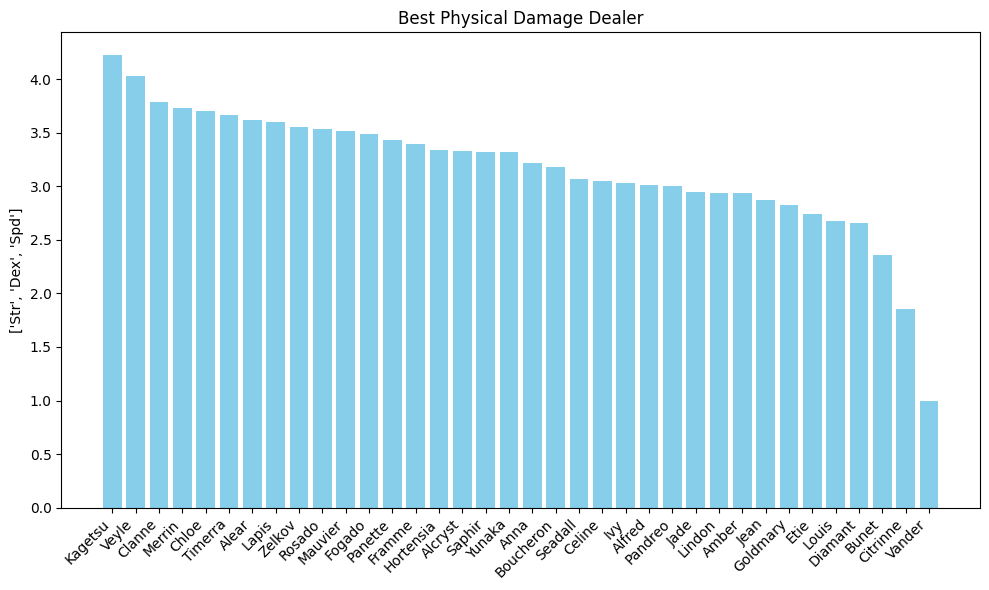

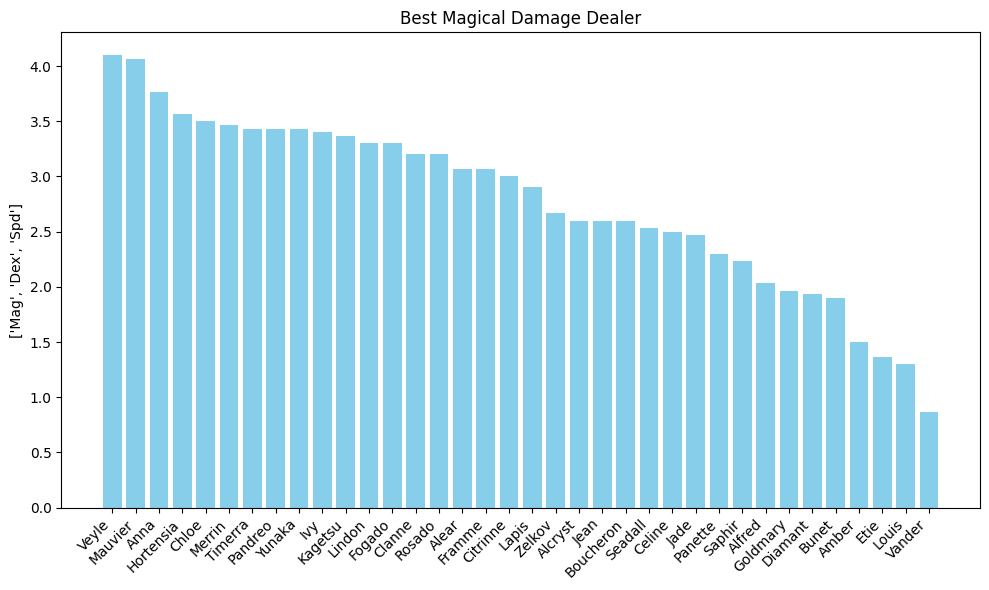

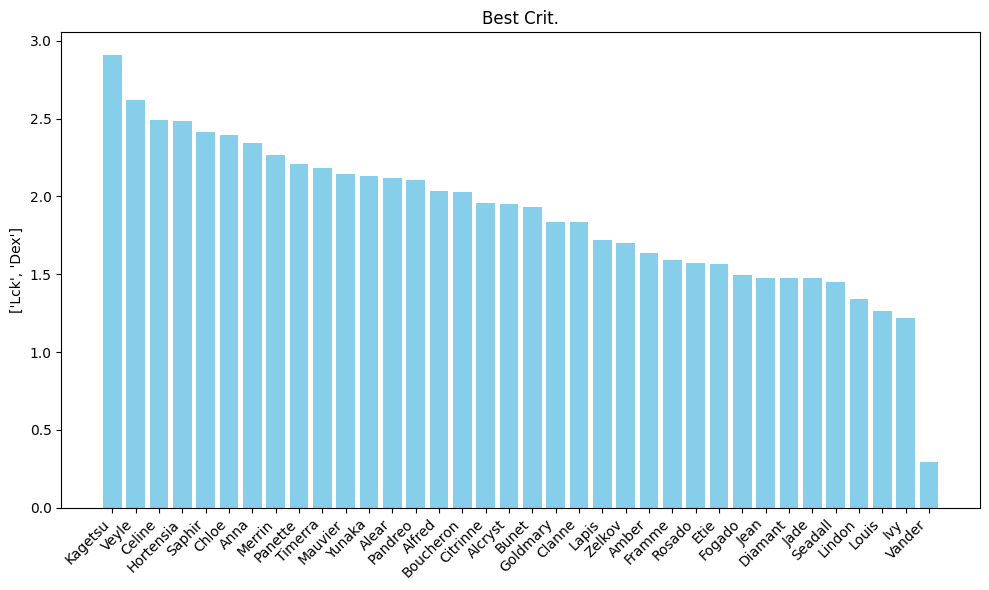

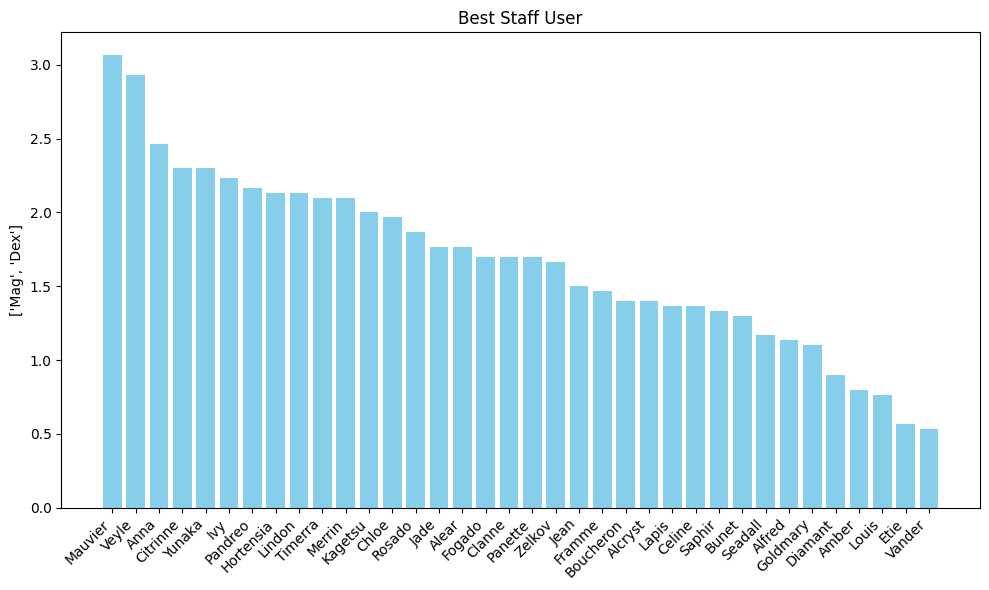

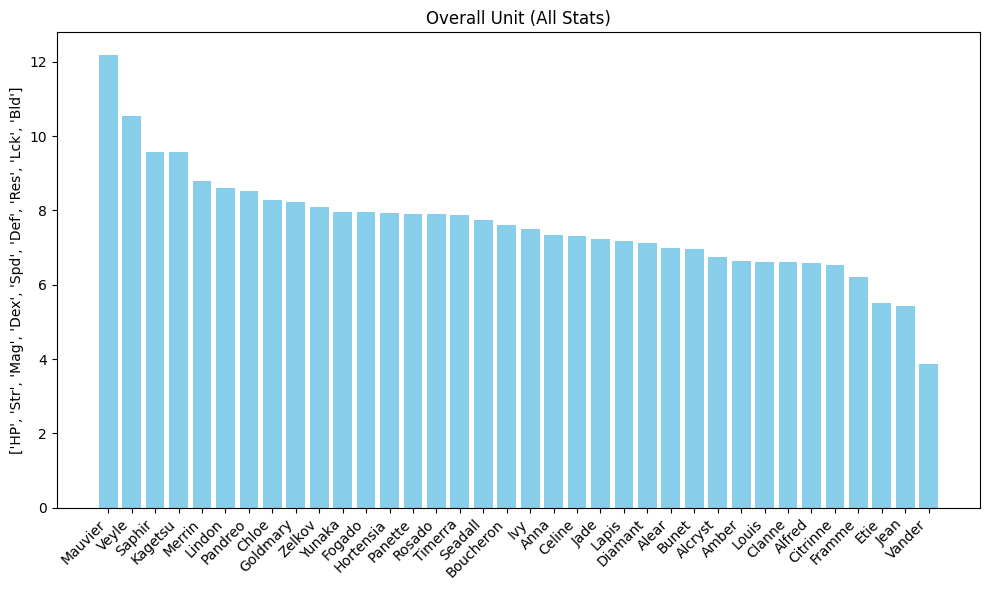

In [10]:

# Physical Damage Dealer 
features = ['Str', 'Dex', 'Spd']
f_name = 'phys_dam'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)
combined_df_sorted = combined_df.sort_values(by=f_name, ascending=False).copy()

plt.figure(figsize=(10, 6))
plt.bar(combined_df_sorted['Name'], combined_df_sorted[f_name], color='skyblue')
plt.ylabel(str(features))
plt.title('Best Physical Damage Dealer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Magical Damage Dealer 
features = ['Mag', 'Dex', 'Spd']
f_name = 'mag_dam'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)
combined_df_sorted = combined_df.sort_values(by=f_name, ascending=False).copy()

plt.figure(figsize=(10, 6))
plt.bar(combined_df_sorted['Name'], combined_df_sorted[f_name], color='skyblue')
plt.ylabel(str(features))
plt.title('Best Magical Damage Dealer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Best Crit. 
features = ['Lck', 'Dex']
f_name = 'crit'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)
combined_df_sorted = combined_df.sort_values(by=f_name, ascending=False).copy()

plt.figure(figsize=(10, 6))
plt.bar(combined_df_sorted['Name'], combined_df_sorted[f_name], color='skyblue')
plt.ylabel(str(features))
plt.title('Best Crit.')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Best Staff User
features = ['Mag', 'Dex']
f_name = 'staff'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)
combined_df_sorted = combined_df.sort_values(by=f_name, ascending=False).copy()

plt.figure(figsize=(10, 6))
plt.bar(combined_df_sorted['Name'], combined_df_sorted[f_name], color='skyblue')
plt.ylabel(str(features))
plt.title('Best Staff User')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# All stats 
features = ['HP','Str','Mag','Dex','Spd','Def','Res','Lck','Bld']
f_name = 'all_stats'
combined_df = normalize_and_combine(features, f_name, df_char_bases, df_char_growths, combined_df)
combined_df_sorted = combined_df.sort_values(by=f_name, ascending=False).copy()

plt.figure(figsize=(10, 6))
plt.bar(combined_df_sorted['Name'], combined_df_sorted[f_name], color='skyblue')
plt.ylabel(str(features))
plt.title('Overall Unit (All Stats)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
